In [1]:
import pandas as pd
import numpy as np

from scipy.stats import shapiro, levene
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

#### **1.ONE-WAY ANOVA** 

| 정규성 | 등분산성 | 사용 검정 | 사후검정 |
|:---:|:---:|---|---|
| ⭕ | ⭕ | One-way ANOVA | Tukey HSD |
| ⭕ | ❌ | Welch ANOVA | Games–Howell |
| ❌ | ⭕ | ANOVA(강건) 또는 Kruskal–Wallis | Tukey 또는 Dunn |
| ❌ | ❌ | Kruskal–Wallis | Dunn |

In [2]:
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/pandas/main/BankChurnersUp.csv',index_col=0)
df.head(3)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887


In [3]:
# 정규성, 등분산성 확인 
res = []
for status  in df['Marital_Status'].unique() : 
    group = df.loc[df['Marital_Status'] == status, 'Credit_Limit']
    stat, p_val = shapiro(group)
    decision = '정규성위반' if p_val < 0.05 else '정규성만족' 
    res.append([status, p_val, decision ])

print(pd.DataFrame(res))


groups = [
    df.loc[df['Marital_Status'] == status, 'Credit_Limit']
    for status in df['Marital_Status'].unique()
]

stat, p_val = levene(*groups)

decision = '등분산성 만족' if p_val > 0.05 else '등분산성 위반'
print('Levene p-value:', p_val)
print(decision)

          0             1      2
0   Married  3.639954e-66  정규성위반
1    Single  4.993659e-61  정규성위반
2   Unknown  3.702207e-31  정규성위반
3  Divorced  3.817500e-31  정규성위반
Levene p-value: 1.600128185015706e-07
등분산성 위반


#### **CASE 1 - ONE-WAY ANOVA (정규, 등분산성 만족)**
**▶ ANOVA - Tueky**

In [4]:
import statsmodels.api as sm 
from statsmodels.formula.api import ols 

# 요인이 3개일때 
model = ols('Credit_Limit ~ C(Marital_Status)', data = df).fit()
res = sm.stats.anova_lm(model)
display(res)

,df,sum_sq,mean_sq,F,PR(>F)
C(Marital_Status),3.0,2.868813e+09,9.562709e+08,11.612706,1.355834e-07
Residual,10123.0,8.335981e+11,8.234695e+07,NaN,NaN


     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
 group1   group2  meandiff  p-adj    lower      upper   reject
--------------------------------------------------------------
Divorced Married -1281.9032 0.0019 -2199.9543 -363.8521   True
Divorced  Single  -358.8803 0.7542 -1288.7753  571.0146  False
Divorced Unknown    86.7181 0.9978 -1118.5525 1291.9886  False
 Married  Single   923.0229    0.0   419.1629 1426.8829   True
 Married Unknown  1368.6213 0.0007   451.0988 2286.1437   True
  Single Unknown   445.5984 0.6065  -483.7746 1374.9714  False
--------------------------------------------------------------


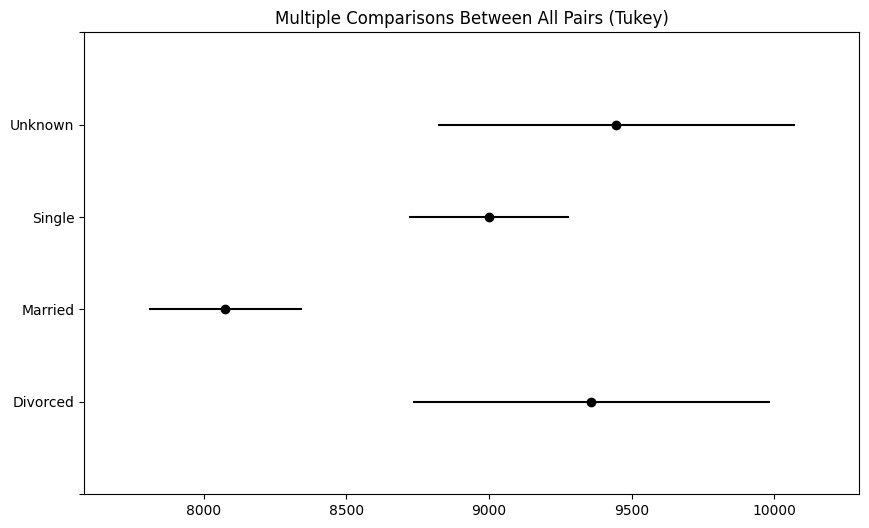

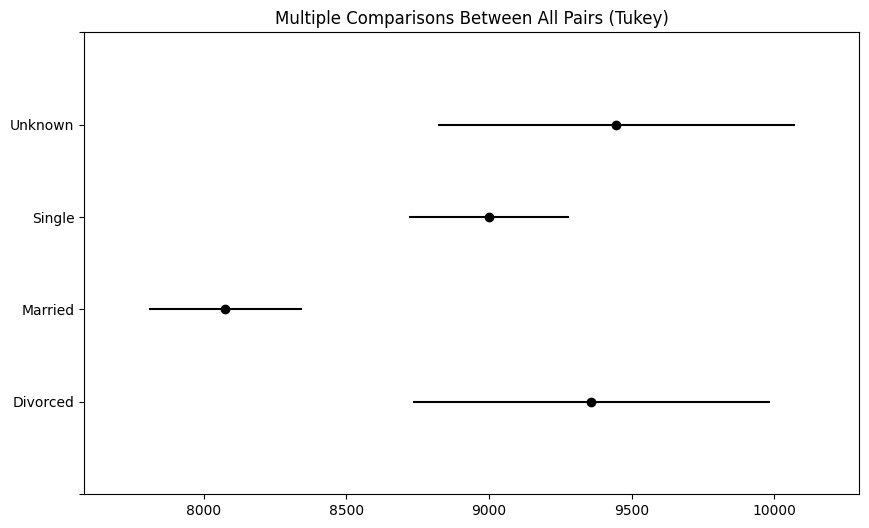

In [5]:
# 사후검정 
from statsmodels.stats.multicomp import pairwise_tukeyhsd 
tukey = pairwise_tukeyhsd(endog = df['Credit_Limit'] , 
                         groups = df['Marital_Status'] , 
                         alpha = 0.05) 

print(tukey)
tukey.plot_simultaneous()

#### **CASE 2 - ONE-WAY ANOVA (정규성 O, 등분산 X)**
**▶ Welch ANOVA/ Gameshowell**

In [6]:
pg.welch_anova(
                dv = 'Credit_Limit', 
                between = 'Marital_Status' , 
                data = df 
)

,Source,ddof1,ddof2,F,p-unc,np2
0,Marital_Status,3,2009.361048,11.665557,1.406893e-07,0.00343


In [7]:
# Games-Howell 
pg.pairwise_gameshowell(
                        dv = 'Credit_Limit' , 
                        between = 'Marital_Status' , 
                        data = df 
)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Divorced,Married,9358.565107,8076.661895,1281.903212,369.465050,3.469620,952.112931,0.003053,0.146907
1,Divorced,Single,9358.565107,8999.684758,358.880349,378.646254,0.947798,1046.229337,0.778988,0.037952
2,Divorced,Unknown,9358.565107,9445.283178,-86.718071,492.671396,-0.176016,1494.970946,0.998063,-0.009094
3,Married,Single,8076.661895,8999.684758,-923.022863,195.920135,-4.711220,8057.207887,0.000015,-0.102628
4,Married,Unknown,8076.661895,9445.283178,-1368.621283,371.129112,-3.687723,951.213282,0.001364,-0.156694
5,Single,Unknown,8999.684758,9445.283178,-445.598420,380.270141,-1.171794,1044.421475,0.644831,-0.047078


#### **CASE 3 ONE-WAY ANOVA (정규성 X, 등분산 O)**
**▶ ANOVA(강건) or Krukal/ Tukey or Dunn test**

In [8]:
# 1. 강건한 ANOVA & Tukey 
model = ols('Credit_Limit ~ C(Marital_Status)', data=df).fit()
sm.stats.anova_lm(model)

pairwise_tukeyhsd(
    endog=df['Credit_Limit'],
    groups=df['Marital_Status']
)

In [9]:
# 2. 비모수적 선택 
from scipy.stats import kruskal 
import scikit_posthocs as sp

groups = [
    df.loc[df['Marital_Status']==g, 'Credit_Limit']
    for g in df['Marital_Status'].unique()
]

kruskal(*groups) 

sp.posthoc_dunn(
    df,
    val_col='Credit_Limit',
    group_col='Marital_Status',
    p_adjust='bonferroni'
)

,Divorced,Married,Single,Unknown
Divorced,1.000000,0.008024,0.960045,1.000000
Married,0.008024,1.000000,0.006883,0.002052
Single,0.960045,0.006883,1.000000,0.457752
Unknown,1.000000,0.002052,0.457752,1.000000


#### **2. ANOVA(Repeated Measures / Paired ANOVA)** 

| 정규성 | 구형성 | 사용 분석 | 사후분석 |
|:---:|:---:|---|---|
| ⭕ | ⭕ | Repeated Measures ANOVA | Bonferroni |
| ⭕ | ❌ | RM ANOVA (GG / HF 보정) | Bonferroni |
| ❌ | ⭕ | RM ANOVA (강건) 또는 Friedman | Dunn |
| ❌ | ❌ | Friedman Test | Dunn |

In [10]:
np.random.seed(42)

df = pd.DataFrame({
    'id': np.arange(1, 21),
    'Before': np.random.normal(70, 5, 20),
    'After1': np.random.normal(75, 5, 20),
    'After2': np.random.normal(78, 5, 20)
})

print(df.head())
print('''
같은 ID 당 before, after1, after2 점수를 측정 
''')

   id     Before     After1     After2
0   1  72.483571  82.328244  81.692333
1   2  69.308678  73.871118  78.856841
2   3  73.238443  75.337641  77.421759
3   4  77.615149  67.876259  76.494482
4   5  68.829233  72.278086  70.607390

같은 ID 당 before, after1, after2 점수를 측정 



In [11]:
# 1. Long Format 
long = df.melt(id_vars = ['id'] , 
              value_name = '점수', 
              var_name = '시점') 

# 2. 정규성 
res = []
for k in long['시점'].unique() : 
    stat, p_val = shapiro(long.loc[long['시점'] == k, '점수'])
    res.append([k, p_val]) 

print(pd.DataFrame(res)) 

# 3. 구형성 
pg.sphericity(
    long,
    dv='점수',
    subject='id',
    within='시점'
)


        0         1
0  Before  0.847880
1  After1  0.767562
2  After2  0.327064


SpherResults(spher=True, W=np.float64(0.9381253177738028), chi2=np.float64(1.1496912815082052), dof=2, pval=np.float64(0.5627917342102342))

#### **CASE 1 : 정규성 O, 구형성 O**
**▶ Repeated Measures ANOVA - Bonferroni**

In [12]:
aov = pg.rm_anova(
                    dv = '점수', 
                    within = '시점', 
                    subject = 'id' , 
                    data = long , 
                    detailed = True
)
print(aov)

# 사후분석 
pg.pairwise_ttests(
                    dv = '점수', 
                    within = '시점', 
                    subject = 'id' , 
                    data = long , 
                    padjust = 'bonf'
)

  Source          SS  DF         MS          F    p-unc       ng2       eps
0     시점  761.277859   2  380.63893  15.895163  0.00001  0.387569  0.941731
1  Error  909.979911  38   23.94684        NaN      NaN       NaN       NaN


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,시점,After1,After2,True,True,-3.128673,19.0,two-sided,0.005530,0.016590,bonf,8.423,-0.916592
1,시점,After1,Before,True,True,2.760495,19.0,two-sided,0.012448,0.037345,bonf,4.271,0.920434
2,시점,After2,Before,True,True,5.312483,19.0,two-sided,0.000040,0.000119,bonf,634.923,1.914506


#### **CASE 2 : 정규성 O, 구형성 X**
**▶ Repeated Measures ANOVA - Bonferroni**

In [13]:
pg.rm_anova(
            dv='점수',
            within='시점',
            subject='id',
            data=long,
            correction=True,   # GG 보정
            detailed=True
)
# 구형성 가정이 위반되어 Greenhouse–Geisser 보정을 적용

,Source,SS,DF,MS,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,시점,761.277859,2,380.63893,15.895163,0.00001,0.000016,0.387569,0.941731,True,0.938125,0.562792
1,Error,909.979911,38,23.94684,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### **CASE 3 : 정규성 X, 구형성 X**
**▶ Friedman Test - Dunn**

In [14]:
from scipy.stats import friedmanchisquare

f = friedmanchisquare(
    df['Before'] , df['After1'] , df['After2']
)
print(f)

# 사후분석 
dunn = sp.posthoc_dunn(
                        long, 
                        val_col = '점수' , 
                        group_col = '시점' , 
                        p_adjust = 'bonferroni'
)
print(dunn)

FriedmanchisquareResult(statistic=np.float64(15.600000000000023), pvalue=np.float64(0.0004097349789797821))
          After1    After2    Before
After1  1.000000  0.040350  0.050525
After2  0.040350  1.000000  0.000003
Before  0.050525  0.000003  1.000000


#### **3.TWO-WAY ANOVA** 
- 상호작용이 유의하면, 주효과는 해석하지 않고 "상호작용을 풀어내기 위한 단순 효과 사후검정"수행
- 등분산성은 Between의 요인 전체 기준
- 1순의 판단 대상은 상호작용
- 상호작용 유의시 - 주효과 해석 X
- 상호작용 없을시 - 사후검정 + 주효과 유의한 요인만 (요인 2개는 Tukey 하지 않음)

## Two-way ANOVA 가정 위반 상황별 분석 및 사후검정 정리
## Two-way ANOVA 가정 충족 여부 및 상호작용에 따른 분석·사후검정 정리

| 정규성 | 등분산성 | 상호작용 | 사용 분석 | 사후검정 기준 | 시각화 |
|---|---|---|---|---|---|
| ⭕ | ⭕ | ⭕ | Two-way ANOVA | **단순효과 사후검정** (조건 고정 후 비교, Tukey) | Interaction plot |
| ⭕ | ⭕ | ❌ | Two-way ANOVA | **주효과 사후검정** (주효과 유의 + 3수준↑ 요인만, Tukey) | Main effect barplot |
| ⭕ | ❌ | ⭕ | Two-way ANOVA (강건 해석) 또는 ART ANOVA | **단순효과 사후검정** (조건 고정 후 비교, Games–Howell) | Interaction plot |
| ⭕ | ❌ | ❌ | Two-way ANOVA (강건 해석) | **주효과 사후검정** (주효과 유의 + 3수준↑ 요인만, Games–Howell) | Main effect barplot |
| ❌ | ⭕ | ⭕ | Two-way ANOVA (CLT 근거) 또는 ART ANOVA | **단순효과 사후검정** (조건 고정 후 비교, Tukey 또는 Dunn) | Interaction plot |
| ❌ | ⭕ | ❌ | Two-way ANOVA (CLT 근거) | **주효과 사후검정** (주효과 유의 + 3수준↑ 요인만, Tukey) | Main effect barplot |
| ❌ | ❌ | ⭕ | **ART ANOVA (권장)** | **단순효과 사후검정** (ART 기반 pairwise / Dunn) | Interaction plot |
| ❌ | ❌ | ❌ | **ART ANOVA (권장)** | **주효과 사후검정** (주효과 유의 + 3수준↑ 요인만, Dunn) | Main effect barplot |


In [18]:
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/pandas/main/BankChurnersUp.csv',index_col=0)
df.head(3)  

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887


In [39]:
# Factor 1 : Education Level
# Facotr 2 : Marital_Status 
res = []
for g in df['Education_Level'].unique() : 
    for m in df['Marital_Status'].unique() : 
        group = df.loc[(df['Education_Level'] == g) & (df['Marital_Status'] == m) , 'Credit_Limit'] 

        s, p = shapiro(group)
        decision = '정규성 만족' if p > 0.05 else '정규성 위배'
   
        res.append([g, m, p, decision]) 

#print(pd.DataFrame(res))


group = [df.loc[(df['Marital_Status'] == g) & (df['Education_Level'] == m) , 'Credit_Limit'] 
         for g in df['Marital_Status'].unique() 
             for m in df['Education_Level'].unique() ] 

ls, lp = levene(*group)
ldecision = '등분산 만족' if p > 0.05 else '등분산 위배'
#print(lp, ldecision)

#### **CASE 1 - TWO-WAY ANOVA (정규, 등분산성 만족)**
**▶ ANOVA - Tukey** 
- 상호작용이 없으면, 주효과를 독립적으로 해석
- 요인이 3개 이상일때 Tukey를 수행 : Gender는 2개라서 의미가 없음 / Martial Status만 수행

In [36]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

m = ols('Credit_Limit ~ C(Education_Level) * C(Marital_Status)' , data = df).fit()
t = anova_lm(m, typ = 2)
display(t)

,sum_sq,df,F,PR(>F)
C(Education_Level),1.818050e+08,6.0,0.367843,8.996846e-01
C(Marital_Status),2.847580e+09,3.0,11.522934,1.544995e-07
C(Education_Level):C(Marital_Status),1.518412e+09,18.0,1.024060,4.276260e-01
Residual,8.318979e+11,10099.0,NaN,NaN


**▶ 사후검정 CASE 1.1 상호작용 X, 주효과기준 Tukey 검정** 

In [51]:
# 1) 상호작용 X , 주효과만 검증 - Tukey (3요인만) 
# 두 개를 각각 하나씩 검증하기 

from statsmodels.stats.multicomp import pairwise_tukeyhsd 

# Education 
t1 = pairwise_tukeyhsd(endog = df['Credit_Limit'] , 
                         groups = df['Education_Level'] , 
                         alpha = 0.05)
#print(t1)

# Martial Status 
t2 = pairwise_tukeyhsd(endog = df['Credit_Limit'] , 
                         groups = df['Marital_Status'] , 
                         alpha = 0.05) 

#print(t2)

##### **▶ 사후검정 CASE 1.2 상호작용 O , 단순효과 사후검정** 
**한 요인을 고정한 상태에서 다른 요인의 수준간 비교**
- 상호작용이 유의하면, 주효과의 유의와 상관없이 단순 효과를 검정

In [54]:
#  1) Martial 고정 >> Education 비교 
for m in df['Marital_Status'].unique() : 
    target = df[df['Marital_Status'] == m] 
    tukey = pairwise_tukeyhsd(endog = target['Credit_Limit'] , groups = target['Education_Level'] , alpha = 0.05)
    #tukey.plot_simultaneous()


# 2) Education 고정 >> Martial_Status 비교 
for e in df['Education_Level'].unique() : 
    sub = df[df['Education_Level'] == e] 
    tukey_e =  pairwise_tukeyhsd(endog = sub['Credit_Limit'] , groups = sub['Marital_Status'] , alpha = 0.05) 

#### **CASE 2 - TWO-WAY ANOVA (정규성 O, 등분산성 X)**
**▶ Two-way ANOVA (강건 해석) 또는 ART ANOVA - Games–Howell** 
##### 2.1 상호작용 유의

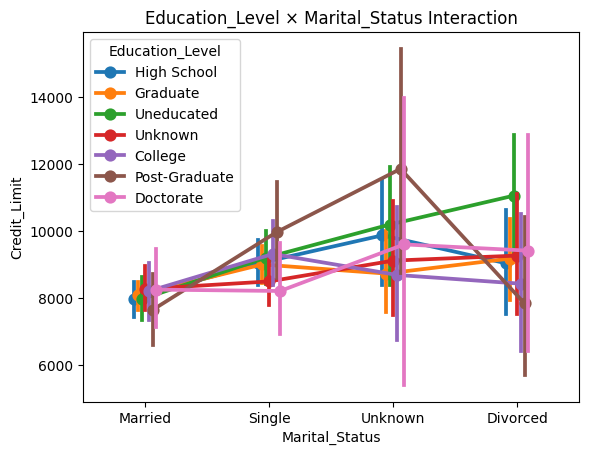

In [72]:
import pingouin as pg

# 강건해석 = 가정 위반을 인정한 상태에서 결과를 제한적으로 해석한다.
# 등분산성이 위배 되지만, 표본수가 충분하고 극단적 불균형이라고 볼 수 없기 때문에 Two way ANOVA를 수행하되 
# 결과를 강건하게 해석한다. 

model = ols('Credit_Limit ~ C(Education_Level) * C(Marital_Status)',    data=df).fit()
anova_res = sm.stats.anova_lm(model, typ=2)
#anova_res

#  1) Martial 고정 >> Education 비교 
for m in df['Marital_Status'].unique() : 
    target = df[df['Marital_Status'] == m] 
    tukey = pg.pairwise_gameshowell(dv = 'Credit_Limit' , between = 'Education_Level' , data = target)
    #tukey.plot_simultaneous()


# 2) Education 고정 >> Martial_Status 비교 
for e in df['Education_Level'].unique() : 
    sub = df[df['Education_Level'] == e] 
    tukey_e =  pg.pairwise_gameshowell(dv = 'Credit_Limit' , between = 'Marital_Status', data = sub ) 


sns.pointplot(
    data=df,
    x='Marital_Status',
    y='Credit_Limit',
    hue='Education_Level',
    dodge=True
)
plt.title('Education_Level × Marital_Status Interaction')
plt.show()

##### 2.2 상호작용 유의하지않음- 주효과만 Gameshowell

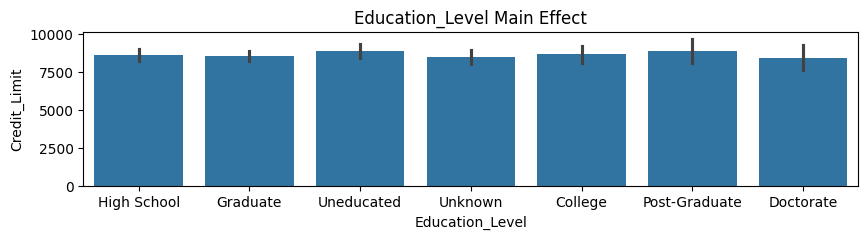

In [69]:
# Education 
pg.pairwise_gameshowell(dv = 'Credit_Limit' , between = 'Education_Level', data = df) 

# Martial Satus
pg.pairwise_gameshowell(dv = 'Credit_Limit' , between = 'Marital_Status', data = df) 

# 시각화 
plt.figure(figsize = (10, 2))
sns.barplot(
    data=df,
    x='Education_Level',
    y='Credit_Limit'
)
plt.title('Education_Level Main Effect')
plt.show()

#### **CASE 3 - TWO-WAY ANOVA (정규성 X, 등분산성 O)**
**▶ Two-way ANOVA (강건 해석) 또는 ART ANOVA - Tukey** 
- 상호작용 유의 → 단순효과 + Tukey + interaction plot
- 상호작용 없음 → 주효과(유의 요인만) + Tukey + barplot

In [73]:
model = ols('Credit_Limit ~ C(Education_Level) * C(Marital_Status)',    data=df).fit()
anova_res = sm.stats.anova_lm(model, typ=2)
#anova_res 

# 1) 상호작용 유의 
#  1) Martial 고정 >> Education 비교 
for m in df['Marital_Status'].unique() : 
    target = df[df['Marital_Status'] == m] 
    tukey =   pairwise_tukeyhsd(endog=target['Credit_Limit'],
                                groups=target['Education_Level'],
                                alpha=0.05 ) 
    #tukey.plot_simultaneous()


# 2) Education 고정 >> Martial_Status 비교 
for e in df['Education_Level'].unique() : 
    sub = df[df['Education_Level'] == e] 
    tukey_e =  pairwise_tukeyhsd(endog=sub['Credit_Limit'],
                                groups=sub['Marital_Status'],
                                alpha=0.05 )  

# 2) 상호작용 유의하지 않음 
pairwise_tukeyhsd(
                    endog=df['Credit_Limit'],
                    groups=df['Education_Level'],
                    alpha=0.05
)

pairwise_tukeyhsd(
                    endog=df['Credit_Limit'],
                    groups=df['Marital_Status'],
                    alpha=0.05
)

#### **CASE 4 - TWO-WAY ANOVA (정규성 X, 등분산성 X)**
**▶ 강건한 해석 (ANOVA)- Dunn** 
- 상호작용 유의 → 단순효과 + Dunn + interaction plot
- 상호작용 없음 → 주효과(유의 요인만) + Dunn + barplot

In [90]:
model = ols('Credit_Limit ~ C(Education_Level) * C(Marital_Status)',  data=df).fit()

anova_ref = sm.stats.anova_lm(model, typ=2)
display(anova_ref)

print('''
중요! 
정규성과 등분산이 모두 위배되어 모수적 이원 분산 분석 결과를 참고용으로 사용하고 해석에는 사용하지 않음
(강건한 해석) 이에 비모수적 접근으로 단순 효과 분석을 수행하여 요인 간 상호작용을 해석했다.
''')

# 1) 상호작용 유의 
#  1) Martial 고정 >> Education 비교 
for m in df['Marital_Status'].unique() : 
    target = df[df['Marital_Status'] == m] 
    tukey =   sp.posthoc_dunn(target, 
                              val_col = 'Credit_Limit' , 
                              group_col = 'Education_Level' , 
                              p_adjust = 'bonferroni' ) 
    #tukey.plot_simultaneous()


# 2) Education 고정 >> Martial_Status 비교 
for e in df['Education_Level'].unique() : 
    sub = df[df['Education_Level'] == e] 
    tukey_e =   sp.posthoc_dunn(sub, 
                                val_col = 'Credit_Limit' , 
                                group_col = 'Marital_Status' , 
                                p_adjust = 'bonferroni' ) 

# 2) 상호작용 없음 - 주효과만 Dunn 검정 
# 2.1) Education 
sp.posthoc_dunn(
                df,
                val_col='Credit_Limit',
                group_col='Education_Level',
                p_adjust='bonferroni'
) 

# 2.2) Martial_Status 
sp.posthoc_dunn(
                df,
                val_col='Credit_Limit',
                group_col='Marital_Status',
                p_adjust='bonferroni'
)

,sum_sq,df,F,PR(>F)
C(Education_Level),1.818050e+08,6.0,0.367843,8.996846e-01
C(Marital_Status),2.847580e+09,3.0,11.522934,1.544995e-07
C(Education_Level):C(Marital_Status),1.518412e+09,18.0,1.024060,4.276260e-01
Residual,8.318979e+11,10099.0,NaN,NaN



중요! 
정규성과 등분산이 모두 위배되어 모수적 이원 분산 분석 결과를 참고용으로 사용하고 해석에는 사용하지 않음
(강건한 해석) 이에 비모수적 접근으로 단순 효과 분석을 수행하여 요인 간 상호작용을 해석했다.



,Divorced,Married,Single,Unknown
Divorced,1.000000,0.008024,0.960045,1.000000
Married,0.008024,1.000000,0.006883,0.002052
Single,0.960045,0.006883,1.000000,0.457752
Unknown,1.000000,0.002052,0.457752,1.000000


#### **3. Mixed ANOVA (혼합분산분석)** 
**▶ TWO WAY ANOVA에서 반복츨정이 들어간 설계** 
1. Two-way ANOVA (between × between) - ID 한번 등장
    예) Between x  Between 성별 X 교육방식
2. Repeated Measures ANOVA (within × within) - ID 여러번 등장, 모든 요인에 반복
    예) Within x Within 
3. Mixed ANOVA (between × within) - ID가 여러번 등장, 요인 일부만 반복
    예) 사람은 집단 하나만 속함 (between) , 같은 사람을 반복 측정 (within) 

#### **3.1 Two-way ANOVA (between × between)** 
**▶ TWO WAY ANOVA에서 반복츨정이 들어간 설계**
1. id가 반복되는가? </br>
   └ 아니오 → between 설계
   
3. 각 id가 요인 A를 몇 개 경험했는가? </br>
   └ 1개 → between</br>
   └ 2개 이상 → repeated
   
5. 각 id가 요인 B를 몇 개 경험했는가? </br>
   └ 1개 → between </br>
   └ 2개 이상 → repeated

In [100]:
np.random.seed(42)
n_per_cell = 20  # 각 조합당 표본 수
data = []
for gender in ['Male', 'Female']:
    for method, mu in zip(
        ['Traditional', 'Online', 'Mixed'],
        [70, 75, 80]  # 교육방식 평균 차이
    ):
        scores = np.random.normal(mu, 8, n_per_cell)
        for s in scores:
            data.append([gender, method, s])
df = pd.DataFrame(
    data,
    columns=['성별', '교육방식', '점수']
)

df['id'] = range(1, len(df) + 1)
df.head(5)

,성별,교육방식,점수,id
0,Male,Traditional,73.973713,1
1,Male,Traditional,68.893886,2
2,Male,Traditional,75.181508,3
3,Male,Traditional,82.184239,4
4,Male,Traditional,68.126773,5


In [106]:
print(df.groupby('id').size().max())
# 1 → 반복측정 아님
print(df.groupby('id')['교육방식'].nunique().max())
# 1 → between
print(df.groupby('id')['성별'].nunique().max())
# 1 → between

1
1
1


#### **Mixed ANOVA (between × within)**
Repeated Measure ANOVA가 아닌 이유는, ID가 여자 일수도, 남자 일수도 있음 </br> 
ID는 Between Subject (독립집단), 하지만 교육방식은 한번씩 다 경험함 (Within Subject) 반복측정 

1. Between - 성별
2. Within - 교육방식 (tradition, online, mix)
3. Subject ID - id
4. 종속변수 - 각 교육방식의 점수

In [93]:
df = pd.read_csv('https://raw.githubusercontent.com/doeungim/ADP_DE2/refs/heads/main/ADP_SONY/ADP_34/data/student_scores.csv')
df.head(5)

,id,성별,traindition,online,mix
0,1,Male,69,74,68
1,2,Male,59,65,63
2,3,Male,60,75,63
3,4,Male,79,52,76
4,5,Male,100,77,67


In [29]:
# 1) Long Format 전환 
df_long = df.melt(id_vars = ['id', '성별'] , 
                   value_name = '점수' , 
                   var_name = '교육방식') 
display(df_long.head())

# 2) 정규성 검정 
res = []

for gender in df_long['성별'].unique() : 
    for way in df_long['교육방식'].unique() : 
        group  = df_long.loc[(df_long['성별'] == gender) & (df_long['교육방식'] == way),'점수']

        stat, p_val = shapiro(group)
        decision = '정규성위반' if p_val < 0.05 else '정규성만족'
        res.append([gender, way, p_val , decision]) 

print(pd.DataFrame(res))

,id,성별,교육방식,점수
0,1,Male,traindition,69
1,2,Male,traindition,59
2,3,Male,traindition,60
3,4,Male,traindition,79
4,5,Male,traindition,100


        0            1         2      3
0    Male  traindition  0.097687  정규성만족
1    Male       online  0.683060  정규성만족
2    Male          mix  0.083163  정규성만족
3  Female  traindition  0.472527  정규성만족
4  Female       online  0.048999  정규성위반
5  Female          mix  0.994322  정규성만족


In [30]:
# 정규성 검토 (성별 × 교육방식) - Wide Form 일때 
res = []
for col in ['traindition','online','mix']:
    for sex, g in df.groupby('성별'):
        stat, p = shapiro(g[col])
        res.append([sex, col, p])

pd.DataFrame(res, columns=['성별','교육방식','p_value'])

,성별,교육방식,p_value
0,Female,traindition,0.472527
1,Male,traindition,0.097687
2,Female,online,0.048999
3,Male,online,0.683060
4,Female,mix,0.994322
5,Male,mix,0.083163


In [31]:
# 등분산성 (성별 기준) 
m = df_long.loc[df_long['성별'] == 'Male', '점수']
f = df_long.loc[df_long['성별'] == 'Female', '점수'] 

stat, p_val = levene(m, f)
decision = '등분산성 만족' if p_val > 0.05 else '등분산성 위반'
print(p_val, decision)
print('''
등분산성은 Between Subejct Factor에만 적용된다. 
서로 다른 집단에 속한 독립 표본간 분산이 같은지를 보는 가정
성별은 사람이 속한 집단 / 교육방법은 같은 사람이 반복 측정된 조건 
''')

0.4313202535973647 등분산성 만족

등분산성은 Between Subejct Factor에만 적용된다. 
서로 다른 집단에 속한 독립 표본간 분산이 같은지를 보는 가정
성별은 사람이 속한 집단 / 교육방법은 같은 사람이 반복 측정된 조건 



In [32]:
# Mixed ANOVA 수행 
aov = pg.mixed_anova(
    dv='점수',
    within='교육방식',
    between='성별',
    subject='id',
    data=df_long
)

aov

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,성별,22.533333,1,38,22.533333,0.199343,0.657785,0.005219,NaN
1,교육방식,117.650000,2,76,58.825000,0.482945,0.618844,0.012550,0.976104
2,Interaction,50.516667,2,76,25.258333,0.207367,0.813179,0.005427,NaN


  Contrast       A            B  Paired  Parametric         T   dof  \
0     교육방식     mix       online    True        True -0.514835  39.0   
1     교육방식     mix  traindition    True        True  0.478733  39.0   
2     교육방식  online  traindition    True        True  1.000655  39.0   

  alternative     p-unc    p-corr p-adjust   BF10    hedges  
0   two-sided  0.609574  1.000000     bonf  0.193 -0.107786  
1   two-sided  0.634802  1.000000     bonf   0.19  0.112853  
2   two-sided  0.323162  0.969487     bonf  0.272  0.226435  


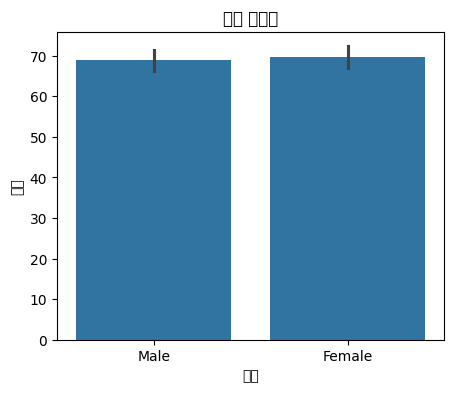

    Contrast         교육방식       A            B Paired Parametric         T  \
0       교육방식            -     mix       online   True       True -0.514835   
1       교육방식            -     mix  traindition   True       True  0.478733   
2       교육방식            -  online  traindition   True       True  1.000655   
3         성별            -  Female         Male  False       True  0.446479   
4  교육방식 * 성별          mix  Female         Male  False       True  0.434880   
5  교육방식 * 성별       online  Female         Male  False       True  0.601592   
6  교육방식 * 성별  traindition  Female         Male  False       True -0.275289   

    dof alternative     p-unc    p-corr p-adjust   BF10    hedges  
0  39.0   two-sided  0.609574  1.000000     bonf  0.193 -0.107786  
1  39.0   two-sided  0.634802  1.000000     bonf   0.19  0.112853  
2  39.0   two-sided  0.323162  0.969487     bonf  0.272  0.226435  
3  38.0   two-sided  0.657785       NaN      NaN  0.334  0.138384  
4  38.0   two-sided  0.666110  1.00

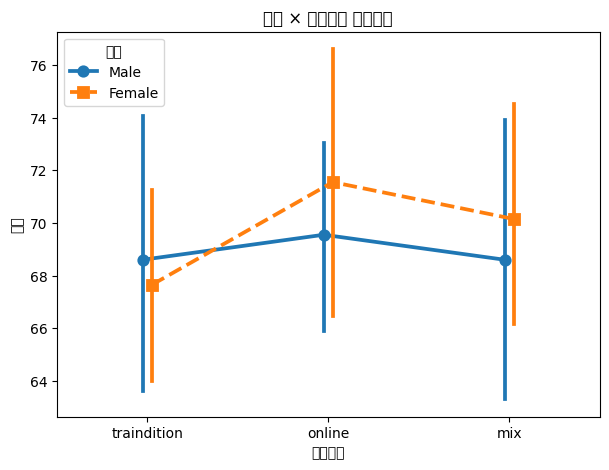

In [37]:
# 교육방식 주효과 검정 
posted = pg.pairwise_ttests(
                            dv = '점수' , 
                            within = '교육방식', 
                            subject = 'id' , 
                            data = df_long, 
                            padjust = 'bonf'
)

print(posted)

# 성별 주효과 검정 
plt.figure(figsize=(5,4))
sns.barplot(
    data=df_long,
    x='성별',
    y='점수'
)
plt.title('성별 주효과')
plt.show() 


# 성별과 교육방식의 상호작용이 있을때 
posted_interaction = pg.pairwise_ttests(
                            dv = '점수' , 
                            between = '성별', 
                            within = '교육방식', 
                            subject = 'id' , 
                            data = df_long, 
                            padjust = 'bonf'
)

print(posted_interaction)

plt.figure(figsize=(7,5))
sns.pointplot(
    data=df_long,
    x='교육방식',
    y='점수',
    hue='성별',
    dodge=True,
    markers=['o','s'],
    linestyles=['-','--']
)
plt.title('성별 × 교육방식 상호작용')
plt.show()